In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use("./../figures/plotting.mplstyle")
import numpy as np
from scipy.special import erf
import h5py

import sys
sys.path.append('./../figures')
from makeCorner import plot_corner

sys.path.append('./../code/')
from utilities import truncated_gaussian

Load the sumary file containing output of our autoregressive inference on the $ln\,m_1$ and $q$ distributions of BBHs:

In [2]:
hdata = h5py.File("/Volumes/LaCie/cca/autoregressive-bbh-inference-data/ar_lnm1_q_summary.hdf","r")

# List attributes
for key in hdata.attrs.keys():
    print("{0}: {1}".format(key,hdata.attrs[key]))
    
# List groups and datasetes
print("\nGroups:")
print(hdata.keys())

print("\nData sets inside ['posterior']:")
print(hdata['posterior'].keys())

Created_by: process_lnm1_q.py
Downloadable_from: 10.5281/zenodo.7600141
Source_code: https://github.com/tcallister/autoregressive-bbh-inference

Groups:
<KeysViewHDF5 ['posterior']>

Data sets inside ['posterior']:
<KeysViewHDF5 ['R_ref', 'ar_lnm1_std', 'ar_lnm1_tau', 'ar_q_std', 'ar_q_tau', 'dR_dlnm1s', 'dR_dqs', 'f_lnm1s', 'f_qs', 'kappa', 'logsig_chi', 'm1s', 'min_log_neff', 'mu_chi', 'nEff_inj_per_event', 'qs', 'sig_cost']>


The different `hdata['posterior/']` datasets correspond to the following:

| Name      | Description |
| :---------- | :---------- |
| `R_ref`     | The mean on our AR1 processes over $\ln m_1$ and $q$ at $m_1=20\,M_\odot$, $q=1$, and $z=0.2$  |
| `ar_lnm1_std` | The square of this is the prior variance of our AR process over $\ln m_1$ per autocorrelation length |
| `ar_lnm1_tau` | The autocorrelation length of our AR process over $\ln m_1$ |
| `ar_q_std` | The square of this is the prior variance of our AR process over $q$ per autocorrelation length |
| `ar_q_tau` | The autocorrelation length of our AR process over $q$ |
| `dR_dlnm1s` | The source-frame volumetric merger $\frac{d\mathcal{R}}{d\ln m_1\,dq}$ as a function of mass, evaluated at $q=1$ and $z=0.2$ (and marginalized over spin), with units $\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}$ |
| `dR_dqs` | The source-frame volumetric merger $\frac{d\mathcal{R}}{d\ln m_1\,dq}$ as a function of mass ratio, evaluated at $m_1=20\,M_\odot$ and $z=0.2$ (and marginalized over spin), with units $\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}$ |
| `f_lnm1s` | The logarithm of this quantity is our AR1 process over $\ln m_1$; this quantity is proportional to `dR_dlnm1s` |
| `f_qs` | The logarithm of this quantity is our AR1 process over $q$; this quantity is proportional to `dR_dqs` |
| `m1s` | Set of primary masses over which `dR_dlnm1s` and `f_lnm1s` are defined |
| `qs` | Set of primary masses over which `dR_dqs` and `f_qs` are defined |
| `kappa` | This is the power-law index governing growth of the merger rate, assumed to evolve as $(1+z)^\kappa$ |
| `mu_chi` | The mean of component spin magnitudes |
| `logsig_chi` | Log10 of the standard deviation of component spin magnitudes |
| `sig_cost` | Standard deviation of spin-orbit misalignment angles (mean assumed to be `1`) |
| `nEff_inj_per_event` | Number of effective injections per event informing our Monte Carlo estimate of detection efficiency |
| `min_log_neff` | For each posterior sample, minimum (log10) number of effective posterior samples informing our Monte Carlo estimates of each event's likelihood, taken over all events |

Make a big corner plot of all these quantities:

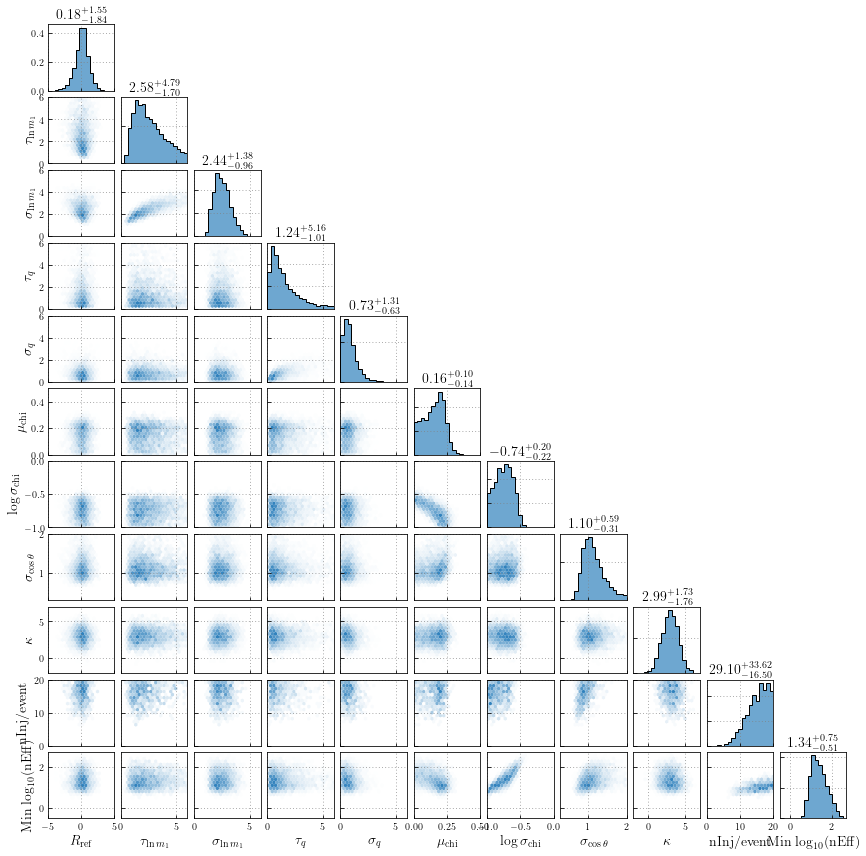

In [3]:
plot_data = {
    'R_ref':{'data':np.log10(hdata['posterior/R_ref'][()]),'plot_bounds':(-5,5),'label':r'$R_\mathrm{ref}$'},
    'lnm1_tau':{'data':hdata['posterior/ar_lnm1_tau'][()],'plot_bounds':(0,6),'label':r'$\tau_{\ln m_1}$'},
    'lnm1_std':{'data':hdata['posterior/ar_lnm1_std'][()],'plot_bounds':(0,6),'label':r'$\sigma_{\ln m_1}$'},
    'q_tau':{'data':hdata['posterior/ar_q_tau'][()],'plot_bounds':(0,6),'label':r'$\tau_q$'},
    'q_std':{'data':hdata['posterior/ar_q_std'][()],'plot_bounds':(0,6),'label':r'$\sigma_q$'},
    'mu_chi':{'data':hdata['posterior/mu_chi'][()],'plot_bounds':(0,0.5),'label':r'$\mu_\mathrm{chi}$'},
    'logsig_chi':{'data':hdata['posterior/logsig_chi'][()],'plot_bounds':(-1,0),'label':r'$\log\sigma_\mathrm{chi}$'},
    'sig_cost':{'data':hdata['posterior/sig_cost'][()],'plot_bounds':(0.3,2),'label':r'$\sigma_{\cos\theta}$'},
    'kappa':{'data':hdata['posterior/kappa'][()],'plot_bounds':(-2,7),'label':r'$\kappa$'},
    'neff':{'data':hdata['posterior/nEff_inj_per_event'][()],'plot_bounds':(0,20),'label':r'nInj/event'},
    'min_neff':{'data':hdata['posterior/min_log_neff'][()],'plot_bounds':(-0.5,2.7),'label':r'Min $\log_{10}$(nEff)'},
}

fig = plt.figure(figsize=(12,12))
plot_corner(fig,plot_data,'#3182bd')
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()

Let's plot the actual measured distributions of BBH parameters:

### 1. Primary mass

The below plot shows the source-frame merger rate density $\frac{d\mathcal{R}}{d\ln m_1 dq}$ evaluated at $q=1$ and $z=0.2$ (marginalized over spins).

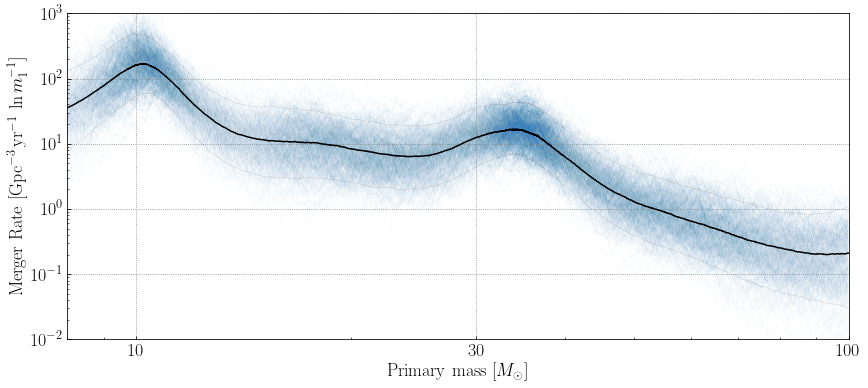

In [21]:
# Extract things from the hdf file
m1s = hdata['posterior/m1s'][()]
dR_dlnm1s = hdata['posterior/dR_dlnm1s'][()]

fig,ax = plt.subplots(figsize=(14,6))

for i in np.random.choice(range(dR_dlnm1s.shape[1]),500):
    ax.plot(m1s,dR_dlnm1s[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

ax.plot(m1s,np.median(dR_dlnm1s,axis=1),color='black')
ax.plot(m1s,np.quantile(dR_dlnm1s,0.05,axis=1),color='grey',lw=0.15)
ax.plot(m1s,np.quantile(dR_dlnm1s,0.95,axis=1),color='grey',lw=0.15)

ax.tick_params(labelsize=18)
ax.set_xlim(8,100)
ax.set_ylim(1e-2,1e3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([10,30,100])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlabel('Primary mass [$M_\odot$]',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]',fontsize=18)

plt.show()

### 2. Mass ratio

The below plot shows the source-frame merger rate density $\frac{d\mathcal{R}}{d\ln m_1 dq}$ evaluated at $m_1=20\,M_\odot$ and $z=0.2$ (marginalized over spins).

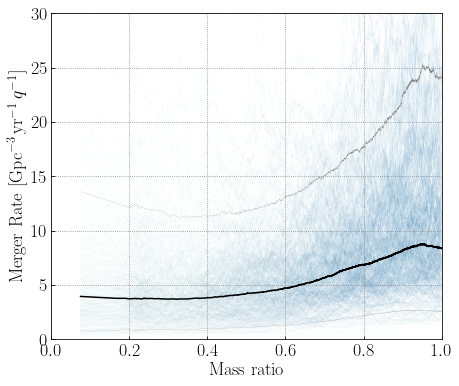

In [24]:
# Extract things from the hdf file
qs = hdata['posterior/qs'][()]
dR_dqs = hdata['posterior/dR_dqs'][()]

fig,ax = plt.subplots(figsize=(7,6))

for i in np.random.choice(range(dR_dqs.shape[1]),500):
    ax.plot(qs,dR_dqs[:,i],color='#3182bd',alpha=0.09,lw=0.09,zorder=0)

ax.plot(qs,np.median(dR_dqs,axis=1),color='black')
ax.plot(qs,np.quantile(dR_dqs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(qs,np.quantile(dR_dqs,0.95,axis=1),color='grey',lw=0.15)

ax.tick_params(labelsize=18)
ax.set_xlim(0,1)
ax.set_ylim(0,30)
ax.set_xlabel('Mass ratio',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,q^{-1}$]',fontsize=18)

plt.show()

We could alternatively plot this as a probability density over $q$:

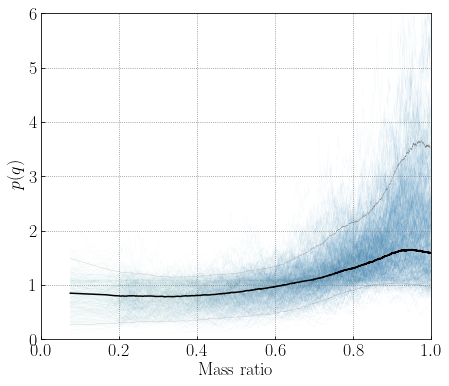

In [25]:
# Loop across posterior samples and defined normalized probability distributions
p_qs = np.zeros(dR_dqs.shape)
for i in range(dR_dqs.shape[1]):
    p_qs[:,i] = dR_dqs[:,i]/np.trapz(dR_dqs[:,i],qs)

# Plot
fig,ax = plt.subplots(figsize=(7,6))
for i in np.random.choice(np.arange(p_qs.shape[1]),500):
    ax.plot(qs,p_qs[:,i],color='#3182bd',alpha=0.09,lw=0.09,zorder=0)

ax.plot(qs,np.median(p_qs,axis=1),color='black')
ax.plot(qs,np.quantile(p_qs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(qs,np.quantile(p_qs,0.95,axis=1),color='grey',lw=0.15)

ax.tick_params(labelsize=18)
ax.set_xlim(0,1)
ax.set_ylim(0,6)
ax.set_xlabel('Mass ratio',fontsize=18)
ax.set_ylabel('$p(q)$',fontsize=18)

plt.show()

### 3. Component spin magnitudes

The probability distribution of component spin magnitudes (assuming they are independently and identically distributed):

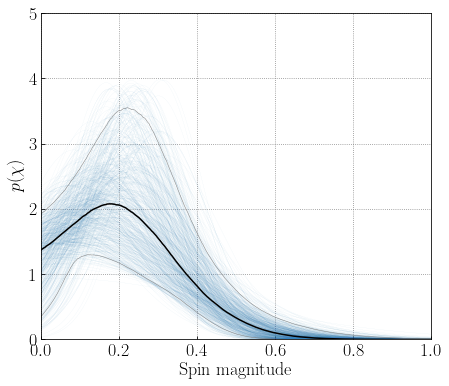

In [22]:
# Extract parameters from h5 file
mu_chis = hdata['posterior/mu_chi'][()]
logsig_chis = hdata['posterior/logsig_chi'][()]

# Grid over which to evaluate and plot probabilities
chi_grid = np.linspace(0,1,1000)

# Loop across samples and construct probability distributions
p_chis = np.zeros((mu_chis.size,chi_grid.size))
for i in range(mu_chis.size):
    p_chis[i,:] = truncated_gaussian(chi_grid,mu_chis[i],10.**logsig_chis[i],-1,1)

# Plot
fig,ax = plt.subplots(figsize=(7,6))
for i in np.random.choice(np.arange(mu_chis.size),700):
    ax.plot(chi_grid,p_chis[i,:],color='#3182bd',alpha=0.15,lw=0.15)
    
ax.plot(chi_grid,np.median(p_chis,axis=0),color='black')
ax.plot(chi_grid,np.quantile(p_chis,0.05,axis=0),color='grey',lw=0.5)
ax.plot(chi_grid,np.quantile(p_chis,0.95,axis=0),color='grey',lw=0.5)

ax.tick_params(labelsize=18)
ax.set_xlim(0,1)
ax.set_ylim(0,5)
ax.set_xlabel('Spin magnitude',fontsize=18)
ax.set_ylabel('$p(\chi)$',fontsize=18)
    
plt.show()

### 4. Component spin tilts

The probability distribution of component spin tilts (assuming they are independently and identically distributed):

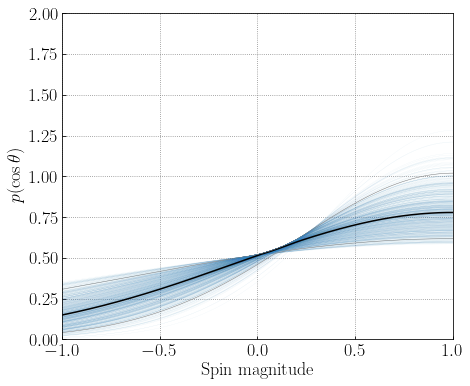

In [26]:
# Extract parameters from h5 file
sig_costs = hdata['posterior/sig_cost'][()]

# Grid over which to evaluate and plot probabilities
cost_grid = np.linspace(-1,1,1000)

# Loop across samples and construct probability distributions
p_costs = np.zeros((sig_costs.size,cost_grid.size))
for i in range(sig_costs.size):
    p_costs[i,:] = truncated_gaussian(cost_grid,1.,sig_costs[i],-1,1)

# Plot
fig,ax = plt.subplots(figsize=(7,6))
for i in np.random.choice(np.arange(sig_costs.size),700):
    ax.plot(cost_grid,p_costs[i,:],color='#3182bd',alpha=0.15,lw=0.15)
    
ax.plot(cost_grid,np.median(p_costs,axis=0),color='black')
ax.plot(cost_grid,np.quantile(p_costs,0.05,axis=0),color='grey',lw=0.5)
ax.plot(cost_grid,np.quantile(p_costs,0.95,axis=0),color='grey',lw=0.5)

ax.tick_params(labelsize=18)
ax.set_xlim(-1,1)
ax.set_ylim(0,2)
ax.set_xlabel('Spin magnitude',fontsize=18)
ax.set_ylabel('$p(\cos\\theta)$',fontsize=18)
    
plt.show()

### 5. Redshifts

Plot the evolution of the merger rate $\frac{d\mathcal{R}}{d\ln m_1 dq}$ across redshift, evaluated at fixed $m_1 = 20\,M_\odot$ and $q=1$.

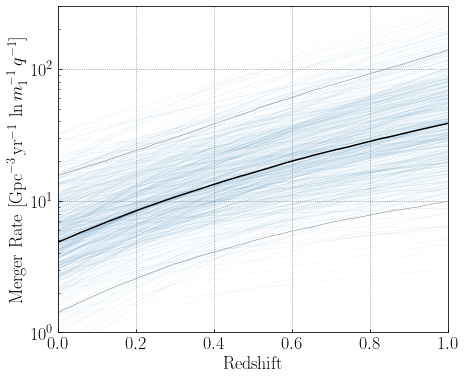

In [19]:
# Extract things from the hdf file
R_ref = hdata['posterior/R_ref'][()]
kappa = hdata['posterior/kappa'][()]
f_lnm1s = hdata['posterior/f_lnm1s'][()]
f_qs = hdata['posterior/f_qs'][()]
m1s = hdata['posterior/m1s'][()]
qs = hdata['posterior/qs'][()]

# Grid over which to evaluate R(z)
z_grid = np.linspace(0,1.5,500)
R_zs = np.zeros((R_ref.size,z_grid.size))

# Get values of AR processes at our reference values of m1 and q
ind_m1_20 = np.argmin(np.abs(m1s-20.))
f_lnm1_20 = f_lnm1s[ind_m1_20,:]
f_q_1 = f_qs[-1,:]

for i in range(R_ref.size):
    
    # Construct merger rate at z=0.2, m1=20, and q=1
    # By definition, R_ref is already evaluated at z=0.2
    R_z_02 = R_ref[i]*f_lnm1_20[i]*f_q_1[i]
    
    # Now extend across all redshifts according to our power law model
    R_zs[i,:] = R_z_02*((1.+z_grid)/(1.+0.2))**kappa[i]

fig,ax = plt.subplots(figsize=(7,6))

for i in np.random.choice(range(R_zs.shape[0]),500):
    ax.plot(z_grid,R_zs[i,:],color='#3182bd',alpha=0.25,lw=0.15,zorder=0)

ax.plot(z_grid,np.median(R_zs,axis=0),color='black')
ax.plot(z_grid,np.quantile(R_zs,0.05,axis=0),color='grey',lw=0.5)
ax.plot(z_grid,np.quantile(R_zs,0.95,axis=0),color='grey',lw=0.5)

ax.tick_params(labelsize=18)
ax.set_xlim(0,1.)
ax.set_ylim(1,300)
ax.set_yscale('log')
ax.set_xlabel('Redshift',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}\,q^{-1}$]',fontsize=18)

plt.show()

Instead integrate $\frac{d\mathcal{R}}{d\ln m_1 dq}$ over log-mass and mass ratio, plotting the total inferred merger rate vs. $z$:

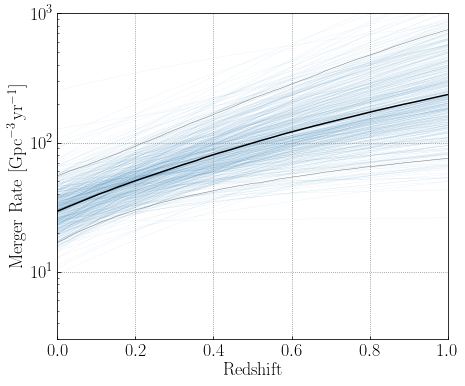

In [20]:
# Extract things from the hdf file
R_ref = hdata['posterior/R_ref'][()]
kappa = hdata['posterior/kappa'][()]
f_lnm1s = hdata['posterior/f_lnm1s'][()]
f_qs = hdata['posterior/f_qs'][()]
m1s = hdata['posterior/m1s'][()]
qs = hdata['posterior/qs'][()]

# Grid over which to evaluate R(z)
z_grid = np.linspace(0,1.5,500)
R_zs = np.zeros((R_ref.size,z_grid.size))

for i in range(R_ref.size):
    
    # Form integrals over log-mass and mass ratio
    f_lnm1_integral = np.trapz(f_lnm1s[:,i],np.log(m1s))
    f_q_integral = np.trapz(f_qs[:,i],qs)
    
    # Construct merger rates over all z
    R_zs[i,:] = R_ref[i]*f_lnm1_integral*f_q_integral*((1.+z_grid)/(1.+0.2))**kappa[i]

fig,ax = plt.subplots(figsize=(7,6))

for i in np.random.choice(range(R_zs.shape[0]),500):
    ax.plot(z_grid,R_zs[i,:],color='#3182bd',alpha=0.25,lw=0.15,zorder=0)

ax.plot(z_grid,np.median(R_zs,axis=0),color='black')
ax.plot(z_grid,np.quantile(R_zs,0.05,axis=0),color='grey',lw=0.5)
ax.plot(z_grid,np.quantile(R_zs,0.95,axis=0),color='grey',lw=0.5)

ax.tick_params(labelsize=18)
ax.set_xlim(0,1.)
ax.set_ylim(3,1000)
ax.set_yscale('log')
ax.set_xlabel('Redshift',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}$]',fontsize=18)

plt.show()